In [53]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_squared_error

plt.style.use("fivethirtyeight")

In [3]:
listings = pd.read_csv("data/listings.csv")
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20191121092222,2019-11-21,Ocean front condo on the sand,Missionbeachretreat. Great Ocean Front Condo...,This charming two bedroom beachfront condomini...,Missionbeachretreat. Great Ocean Front Condo...,none,While some may compare San Diego’s Mission Bea...,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,NaN
1,8488,https://www.airbnb.com/rooms/8488,20191121092222,2019-11-21,Juniper Zen Palace- SD's Best Hood!,Walk every where in San Diegos most charming a...,Private craftsman home in the heart of Histori...,Walk every where in San Diegos most charming a...,none,South Park is a charming community and our nei...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.36
2,29967,https://www.airbnb.com/rooms/29967,20191121092222,2019-11-21,"Great home, 10 min walk to Beach","This 2 bedroom, 2 full bathroom home offers al...","This two bedroom (1 CA king bed, 1 queen bed),...","This 2 bedroom, 2 full bathroom home offers al...",none,NaN,...,f,f,moderate,f,f,5,5,0,0,0.53
3,38245,https://www.airbnb.com/rooms/38245,20191121092222,2019-11-21,Point Loma/Liberty Station-NTC,Stay in a 1928 Spanish Style home. Den is dow...,Please note: 1928 home; remodeled in 2015. Co...,Stay in a 1928 Spanish Style home. Den is dow...,none,"This neighborhood is an expensive, high-end Po...",...,f,f,moderate,t,t,3,0,3,0,1.28
4,39516,https://www.airbnb.com/rooms/39516,20191121092222,2019-11-21,Art Studio Retreat/Rustic Cabin,We love having explorers from all over the wor...,"Nestled in South/North Park, a gentrified neig...",We love having explorers from all over the wor...,none,"We love our eclectic neighborhood, with a smal...",...,f,f,strict_14_with_grace_period,t,f,1,1,0,0,3.38


In [4]:
calendar = pd.read_csv("data/calendar.csv")
calendar["date"] = pd.to_datetime(calendar["date"])
parse_price = lambda p: float(p.replace(",", "")[1:])
calendar["price"] = calendar["price"].apply(parse_price)
calendar["adjusted_price"] = calendar["adjusted_price"].apply(parse_price)
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5570,2019-11-21,f,2050.0,2050.0,3,365
1,5570,2019-11-22,f,2050.0,2050.0,3,365
2,5570,2019-11-23,f,2050.0,2050.0,3,365
3,5570,2019-11-24,f,2050.0,2050.0,3,365
4,5570,2019-11-25,f,2050.0,2050.0,3,365


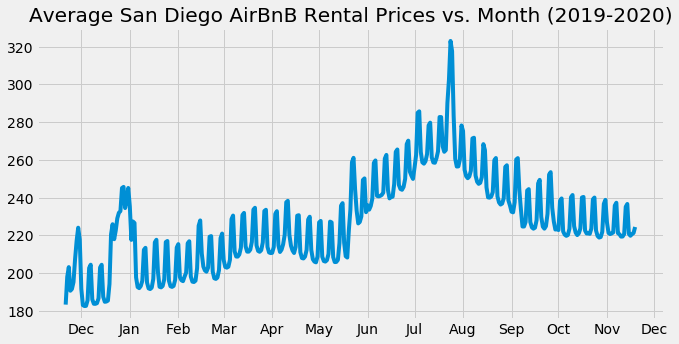

In [5]:
fig = plt.figure(figsize=(10, 5))
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(months_fmt)
plt.title("Average San Diego AirBnB Rental Prices vs. Month (2019-2020)")

# Create and plot time series
avg_prices = calendar.groupby("date").mean()["price"]
plt.plot(avg_prices.index, avg_prices)
plt.savefig("plots/averagePrice.png")

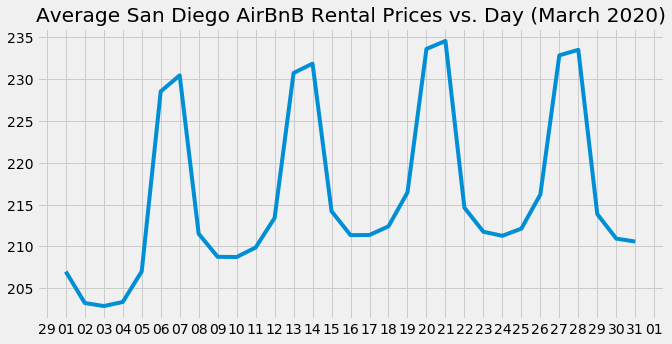

In [6]:
fig = plt.figure(figsize=(10, 5))
days = mdates.DayLocator()
days_fmt = mdates.DateFormatter('%d')
plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(days_fmt)
avg_prices = calendar.groupby("date").mean()["price"]
plt.title("Average San Diego AirBnB Rental Prices vs. Day (March 2020)")

# Create and plot time series of prices in march
march_prices = avg_prices[avg_prices.index.month == 3]
plt.plot(march_prices.index, march_prices);

plt.savefig("plots/averagePrice.png")

In [7]:
deltas = avg_prices.index - pd.DatetimeIndex([datetime.date(2020, 10, 1) for x in range(len(avg_prices))])
train_part = avg_prices[deltas.days < 0]
test_part = avg_prices[~(deltas.days < 0)]
avg_prices

date
2019-11-21    183.263518
2019-11-22    197.970900
2019-11-23    203.130838
2019-11-24    190.625313
2019-11-25    191.547959
                 ...    
2020-11-15    220.735745
2020-11-16    219.767865
2020-11-17    220.604685
2020-11-18    221.224400
2020-11-19    224.404523
Name: price, Length: 365, dtype: float64

In [8]:
train_part

date
2019-11-21    183.263518
2019-11-22    197.970900
2019-11-23    203.130838
2019-11-24    190.625313
2019-11-25    191.547959
                 ...    
2020-09-26    253.467217
2020-09-27    234.605127
2020-09-28    227.417047
2020-09-29    223.048475
2020-09-30    223.340725
Name: price, Length: 315, dtype: float64

In [22]:
dfPro = pd.DataFrame()
dfPro['y'] = train_part
dfPro = dfPro.reset_index().rename(columns = {'date': 'ds'})
dfPro

,ds,y
0,2019-11-21,183.263518
1,2019-11-22,197.970900
2,2019-11-23,203.130838
3,2019-11-24,190.625313
4,2019-11-25,191.547959
...,...,...
310,2020-09-26,253.467217
311,2020-09-27,234.605127
312,2020-09-28,227.417047
313,2020-09-29,223.048475


In [40]:
prophet = Prophet(weekly_seasonality = True)
prophet.fit(dfPro)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


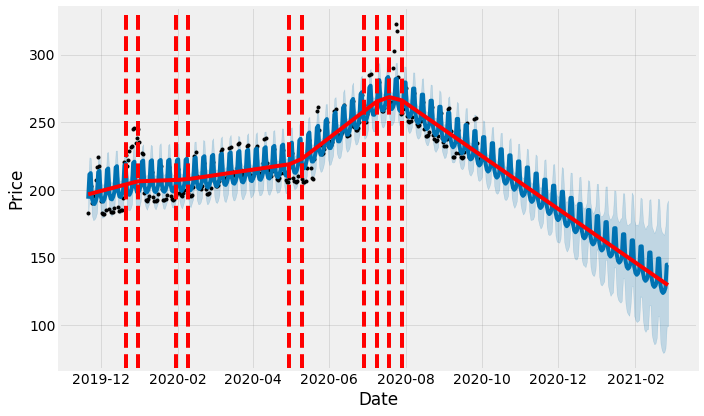

In [46]:
future = prophet.make_future_dataframe(periods= 150, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast, xlabel = 'Date', ylabel = "Price")

a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

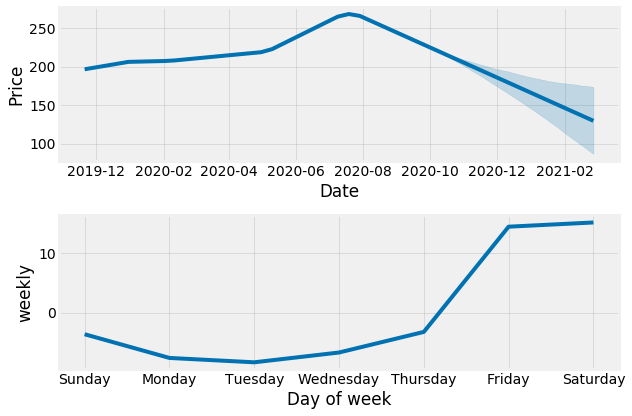

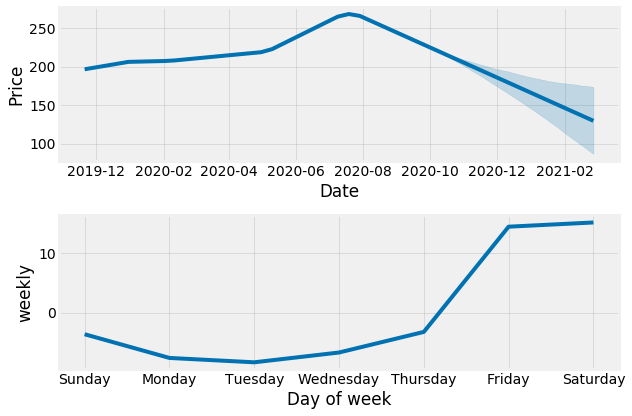

In [47]:
fig2 = prophet.plot_components(forecast)
axes = fig2.get_axes()
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
fig2

In [51]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-21,196.796913,180.610930,206.492597,196.796913,196.796913,-3.256387,-3.256387,-3.256387,-3.256387,-3.256387,-3.256387,0.0,0.0,0.0,193.540526
1,2019-11-22,197.041326,199.480834,224.108436,197.041326,197.041326,14.467193,14.467193,14.467193,14.467193,14.467193,14.467193,0.0,0.0,0.0,211.508519
2,2019-11-23,197.285738,200.344688,223.608388,197.285738,197.285738,15.177544,15.177544,15.177544,15.177544,15.177544,15.177544,0.0,0.0,0.0,212.463282
3,2019-11-24,197.530150,181.019204,207.039063,197.530150,197.530150,-3.646623,-3.646623,-3.646623,-3.646623,-3.646623,-3.646623,0.0,0.0,0.0,193.883527
4,2019-11-25,197.774562,177.739935,201.690443,197.774562,197.774562,-7.640086,-7.640086,-7.640086,-7.640086,-7.640086,-7.640086,0.0,0.0,0.0,190.134476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2021-02-23,132.282122,79.682947,167.745540,90.784832,174.598895,-8.375778,-8.375778,-8.375778,-8.375778,-8.375778,-8.375778,0.0,0.0,0.0,123.906345
461,2021-02-24,131.641392,80.021612,166.761839,89.757524,174.467114,-6.725864,-6.725864,-6.725864,-6.725864,-6.725864,-6.725864,0.0,0.0,0.0,124.915529
462,2021-02-25,131.000662,83.122403,173.590786,88.736676,174.289138,-3.256387,-3.256387,-3.256387,-3.256387,-3.256387,-3.256387,0.0,0.0,0.0,127.744275
463,2021-02-26,130.359933,99.071679,189.168810,87.739768,173.959324,14.467193,14.467193,14.467193,14.467193,14.467193,14.467193,0.0,0.0,0.0,144.827126


In [48]:
df_cv = cross_validation(prophet, initial = '10 days' , horizon = '30 days')
df_cv.head()

INFO:fbprophet:Making 19 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-08-31 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-06,188.233363,187.056400,189.305583,202.664800,2019-12-05
1,2019-12-07,181.670379,179.092459,183.696507,204.421320,2019-12-05
2,2019-12-08,156.318423,151.222581,160.965513,186.066893,2019-12-05
3,2019-12-09,147.908004,139.717311,154.949577,183.698320,2019-12-05
4,2019-12-10,145.453927,134.398367,155.424535,183.674156,2019-12-05


In [57]:
train_error = np.sqrt(mean_squared_error(train_part, df_cv['yhat'].iloc[:len(train_part)]))
test_error = np.sqrt(mean_squared_error(test_part, df_cv['yhat'].iloc[len(train_part):len(train_part)+len(test_part)]))

In [68]:
print("Prophet Training MSE:", train_error)
print("Prophet Test MSE:", test_error)

Prophet Training MSE: 48.605139884455525
Prophet Test MSE: 16.64261359166329


In [59]:
test_error

16.64261359166329

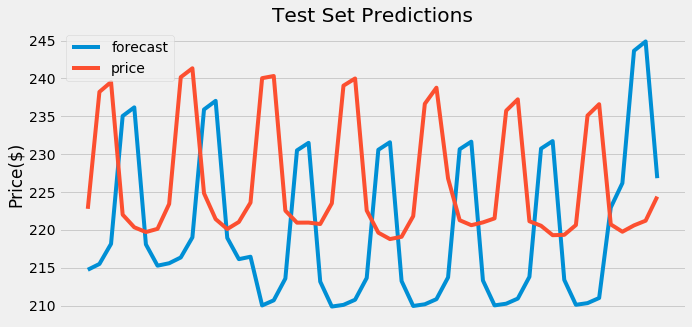

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.ylabel("Price($)")
plt.title("Test Set Predictions")
plt.plot(df_cv['yhat'].iloc[len(train_part):len(train_part)+len(test_part)].reset_index(drop=True))
plt.plot(test_part.values)
plt.legend(["forecast", "price"]);

In [49]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,300.403756,17.332160,12.733442,0.057893,0.037606,0.701754
1,4 days,382.126632,19.548060,14.104541,0.064376,0.038867,0.666667
2,5 days,446.588424,21.132639,15.149863,0.068475,0.039487,0.631579
3,6 days,486.835721,22.064354,15.923623,0.070559,0.040392,0.614035
4,7 days,497.177216,22.297471,16.494808,0.071889,0.045918,0.596491
5,8 days,529.721598,23.015682,17.004675,0.074286,0.047127,0.561404
6,9 days,582.466565,24.134344,17.457135,0.077698,0.047127,0.561404
7,10 days,688.407091,26.237513,18.469693,0.084124,0.058647,0.561404
8,11 days,803.117397,28.339326,19.739528,0.090619,0.060705,0.526316
9,12 days,872.966870,29.546013,20.924793,0.096010,0.063080,0.491228


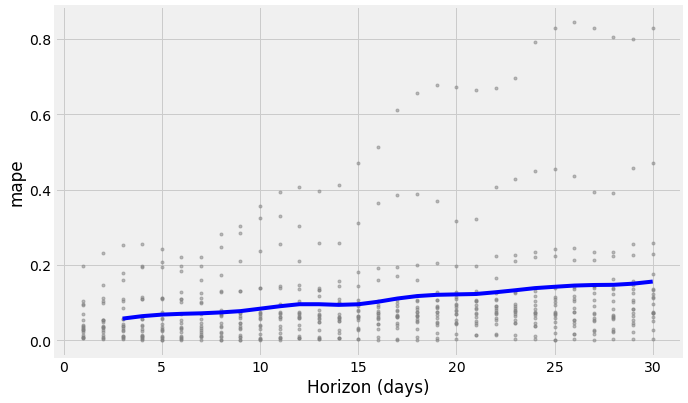

In [50]:
fig = plot_cross_validation_metric(df_cv, metric='mape')